In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import date, datetime, timedelta

# 1. Gather data

In [2]:
data = duckdb.query(
    """
    SELECT appl_id, 
           project_num_split.*,
           agency_ic_fundings[1].name ic_name,
           award_notice_date,
           award_amount
    FROM read_json('../../../data/json/projects/year_added=202*/*/*')
    WHERE award_notice_date >= '2021-01-01'
    """
).to_df()

data["award_notice_date"] = data.award_notice_date.apply(lambda dt: dt.date())
data = data.sort_values("award_notice_date")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# 2. Total awards and total funding by year

In [3]:
award_count_by_date = (
    data[~data.appl_type_code.isna()].groupby([
        "award_notice_date"
    ]).appl_id
      .count()
      .rename("award_count")
      .reset_index()
)

award_count_by_date["year"] = award_count_by_date.award_notice_date.apply(
    lambda x: x.year
)
award_count_by_date["day_of_year"] = award_count_by_date.award_notice_date.apply(
    lambda x: (x - date(x.year - 1, 12, 31)).days
)
award_count_by_date["cumulative_award_count"] = award_count_by_date.groupby("year").apply(
    lambda df: df.award_count.cumsum(),
    include_groups = False
).values

day_of_year_cutoff = (date(2025, 3, 16) - date(2024, 12, 31)).days
select = award_count_by_date.day_of_year < day_of_year_cutoff
award_count_by_date = award_count_by_date[select]
award_count_by_date.to_csv(
    "/home/jovyan/public/weekly/week_of_2025_03_16/data/award_count_by_date.csv",
    index=False
)

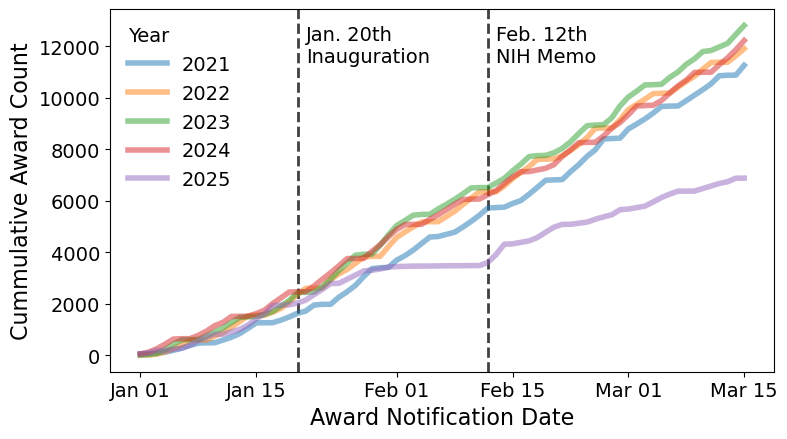

In [4]:
plt.figure(figsize=[8, 4.5])

plt.axvline(
    x = 20,
    lw = 2,
    alpha = .75,
    color = "black",
    linestyle = "dashed"
)
plt.text(
    x = 21,
    y = max(award_count_by_date.cumulative_award_count),
    s = "Jan. 20th\nInauguration",
    size = 14,
    va = "top"
)

plt.axvline(
    x = (date(2025, 2, 12) - date(2024, 12, 31)).days,
    lw = 2,
    alpha = .75,
    color = "black",
    linestyle = "dashed"
)
plt.text(
    x = (date(2025, 2, 12) - date(2024, 12, 31)).days + 1,
    y = max(award_count_by_date.cumulative_award_count),
    s = "Feb. 12th\nNIH Memo",
    size = 14,
    va = "top"
)

sns.lineplot(
    x = award_count_by_date.day_of_year,
    y = award_count_by_date.cumulative_award_count,
    hue = award_count_by_date.year.astype("str"),
    lw = 4,
    alpha = .5
)

x_axis_breakpoints = np.concat([
    [
        (date(2025, i, 1) - date(2024, 12, 31)).days,
        (date(2025, i, 15) - date(2024, 12, 31)).days
    ]
    for i in range(1, 4)
])
x_axis_labels = np.concat([
    [
        date(2025, i, 1).strftime("%b %d"),
        date(2025, i, 15).strftime("%b %d")
    ]
    for i in range(1, 4)
])
plt.xticks(
    x_axis_breakpoints,
    x_axis_labels
)

plt.xlabel(
    "Award Notification Date",
    size = 16
)
plt.ylabel(
    "Cummulative Award Count",
    size = 16
)
plt.tick_params(
    labelsize = 14
)

plt.legend(
    title="Year",
    title_fontsize = 14,
    fontsize = 14,
    frameon = False
)._legend_box.align = "left"

plt.tight_layout()
plt.savefig(
    "/home/jovyan/public/weekly/week_of_2025_03_16/figures/award_count_by_date.png",
    dpi = 300
)
plt.show()

In [5]:
award_amount_by_date = (
    data[~data.appl_type_code.isna()].groupby([
        "award_notice_date"
    ]).award_amount
      .sum()
      .rename("award_amount")
      .reset_index()
)

award_amount_by_date["year"] = award_amount_by_date.award_notice_date.apply(
    lambda x: x.year
)
award_amount_by_date["day_of_year"] = award_amount_by_date.award_notice_date.apply(
    lambda x: (x - date(x.year - 1, 12, 31)).days
)
award_amount_by_date["cumulative_award_amount"] = award_amount_by_date.groupby("year").apply(
    lambda df: df.award_amount.cumsum(),
    include_groups = False
).values
award_amount_by_date.to_csv(
    "/home/jovyan/public/weekly/week_of_2025_03_16/data/award_amount_by_date.csv",
    index=False
)

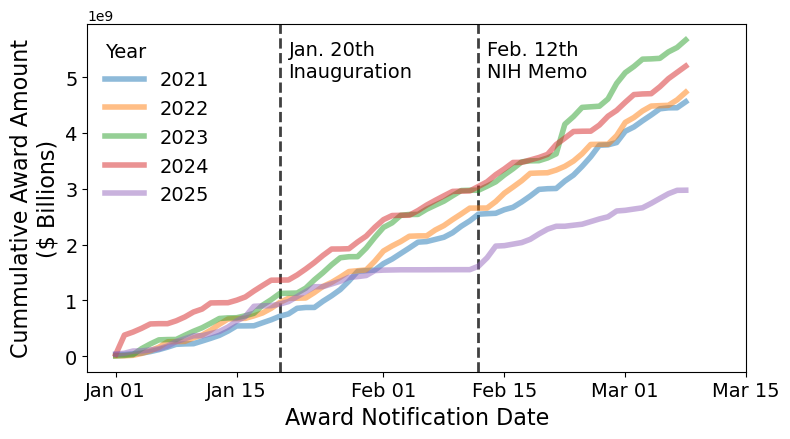

In [6]:
plt.figure(figsize=[8, 4.5])

day_of_year_cutoff = (date(2025, 3, 9) - date(2024, 12, 31)).days
select = award_amount_by_date.day_of_year < day_of_year_cutoff

plt.axvline(
    x = 20,
    lw = 2,
    alpha = .75,
    color = "black",
    linestyle = "dashed"
)
plt.text(
    x = 21,
    y = max(award_amount_by_date[select].cumulative_award_amount),
    s = "Jan. 20th\nInauguration",
    size = 14,
    va = "top"
)

plt.axvline(
    x = (date(2025, 2, 12) - date(2024, 12, 31)).days,
    lw = 2,
    alpha = .75,
    color = "black",
    linestyle = "dashed"
)
plt.text(
    x = (date(2025, 2, 12) - date(2024, 12, 31)).days + 1,
    y = max(award_amount_by_date[select].cumulative_award_amount),
    s = "Feb. 12th\nNIH Memo",
    size = 14,
    va = "top"
)

sns.lineplot(
    x = award_amount_by_date[select].day_of_year,
    y = award_amount_by_date[select].cumulative_award_amount,
    hue = award_amount_by_date[select].year.astype("str"),
    lw = 4,
    alpha = .5
)

x_axis_breakpoints = np.concat([
    [
        (date(2025, i, 1) - date(2024, 12, 31)).days,
        (date(2025, i, 15) - date(2024, 12, 31)).days
    ]
    for i in range(1, 4)
])
x_axis_labels = np.concat([
    [
        date(2025, i, 1).strftime("%b %d"),
        date(2025, i, 15).strftime("%b %d")
    ]
    for i in range(1, 4)
])
plt.xticks(
    x_axis_breakpoints,
    x_axis_labels
)

plt.xlabel(
    "Award Notification Date",
    size = 16
)
plt.ylabel(
    "Cummulative Award Amount\n($ Billions)",
    size = 16
)
plt.tick_params(
    labelsize = 14
)

plt.legend(
    title="Year",
    title_fontsize = 14,
    fontsize = 14,
    frameon = False
)._legend_box.align = "left"

plt.tight_layout()
plt.savefig(
    "/home/jovyan/public/weekly/week_of_2025_03_16/figures/award_amount_by_date.png",
    dpi = 300
)
plt.show()

# 2. Awards counts for current year broken down by application type

In [7]:
award_count_by_type = (
    data[~data.appl_type_code.isna()].groupby([
        "award_notice_date",
        "appl_type_code"
    ]).appl_id
      .count()
      .rename("award_count")
      .reset_index()
)

award_count_by_type = award_count_by_type[
    award_count_by_type.award_notice_date >= date(2025, 1, 1)
]
award_count_by_date.to_csv(
    "/home/jovyan/public/weekly/week_of_2025_03_16/data/award_count_2025_by_activity_code.csv",
    index=False
)

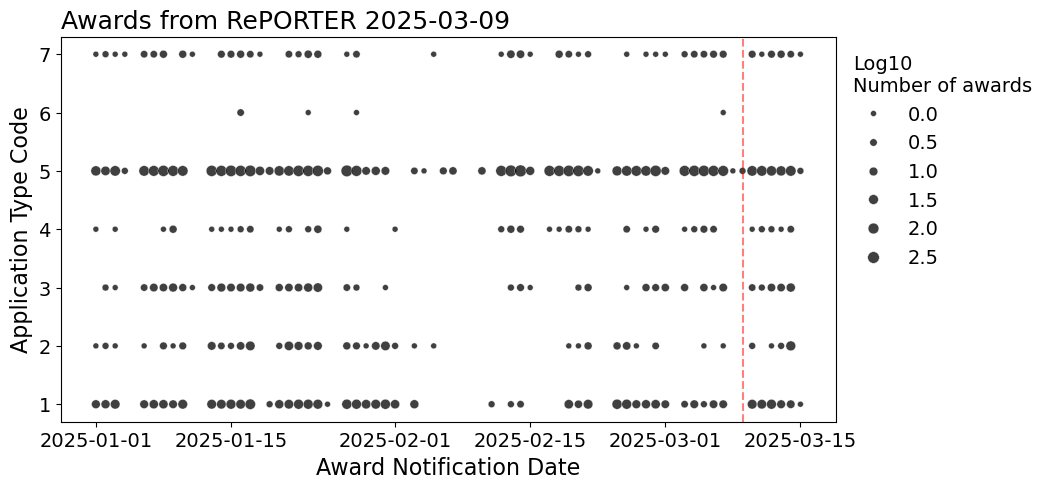

In [8]:
plt.figure(figsize=[10, 5])

sns.scatterplot(
    x = award_count_by_type.award_notice_date,
    y = award_count_by_type.appl_type_code.astype(int),
    size = np.log10(award_count_by_type.award_count),
    color="black",
    alpha=.75
)
plt.axvline(
    x = date(2025, 3, 9),
    color = "red",
    alpha = .5,
    linestyle = "dashed"
)

plt.xlabel(
    "Award Notification Date",
    size = 16
)
plt.ylabel(
    "Application Type Code",
    size = 16
)
plt.tick_params(
    labelsize = 14
)
    
plt.legend(
    title="Log10\nNumber of awards",
    bbox_to_anchor=(1, 1),
    title_fontsize = 14,
    fontsize = 14,
    frameon = False
)._legend_box.align = "left"

plt.title(
    "Awards from RePORTER 2025-03-09",
    size=18,
    loc="left"
)

plt.savefig(
    "/home/jovyan/public/weekly/week_of_2025_03_16/figures/award_count_2025_by_activity_code.png",
    dpi = 300
)
plt.show()